# Machine Learning Practical: Convolutional neural network


In [1]:
#import different package
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import ConstantInit, GlorotUniformInit
from mlp.schedulers import ExponentialLearningRateScheduler, ConstantLearningRateScheduler, ReciprocalLearningRateScheduler
input_dim, output_dim, hidden_dim = 784, 10, 100
import numpy as np
import logging
from mlp.data_providers import MNISTDataProvider
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import mlp.layers as layers
import mlp.initialisers as init
from scipy.signal import convolve2d
import numpy as np

class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        if self.num_input_channels ==1:
            inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1],inputs.shape[2])
            
        #define outputs
        d1=int(self.input_dim_1)-int(self.kernel_dim_1)+1
        d2=int(self.input_dim_2)-int(self.kernel_dim_2)+1
        outputs=np.zeros((((inputs.shape[0],self.num_output_channels,d1,d2))))
        
        #each batch size
        i=0
        for input3 in inputs:
            j=0
            #each output kernel
            for kernelo, biase in zip(self.kernels,self.biases):
                temp=0
                #each input kernel
                for input2,kerneli in zip (input3,kernelo):
                    temp+=convolve2d(input2,kerneli,mode="valid")
                temp+=biase
                outputs[i,j]=temp
                j+=1
            i+=1
                
        return outputs
    
    def bprop(self, inputs, outputs, grads_wrt_outputs):  
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
           
          
        
        """
        if self.num_input_channels ==1:
            inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1],inputs.shape[2])
            
        grads_wrt_inputs=np.zeros((((inputs.shape[0],inputs.shape[1],inputs.shape[2],inputs.shape[3]))))
        
        #for each batch
        i=0
        for grads_wrt_output,output in zip(grads_wrt_outputs,outputs):#for each output and gradsout
          
            for eachK_grad_output, kerneloi, eachK_output in zip(grads_wrt_output,self.kernels,output):#kernel o,i,k1,k2
                #each inputkernel
                temp=[]
                for kerneli in kerneloi:#i
                    temp_c=convolve2d(eachK_grad_output,np.rot90(kerneli,2),mode="full") #k1,k2 here input has to be mapped with fp
                    temp.append(temp_c)
                grads_wrt_inputs[i]+=temp
               
            i+=1
                #after loop of input, store them 
        return grads_wrt_inputs
                
        

    def grads_wrt_params(self, inputs, grads_wrt_outputs): 
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
            
        Calculates gradients with respect to layer parameters.
        
        """
            
        if self.num_input_channels ==1:
            inputs = inputs.reshape(inputs.shape[0],1,inputs.shape[1],inputs.shape[2])
            
        grads_wrt_kernels=np.zeros((((self.num_output_channels, self.num_input_channels, self.kernel_dim_1, self.kernel_dim_2))))
        #num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        grads_wrt_biases =np.zeros(self.num_output_channels)#b的维度=kernel的output。
        
        #for each batch
        for grads_wrt_output,input3 in zip(grads_wrt_outputs,inputs):#for each output and gradsout
            #each outputkernel
            temp_b=[]
            temp_k=[]
            for eachK_grad_output in grads_wrt_output:#kernel o,i,k1,k2
                temp_b.append(eachK_grad_output.sum())
                # each inputkernel
                temp=[]
                for input2 in input3:
                    temp_c=convolve2d(np.rot90(input2,2),eachK_grad_output,mode="valid")
                    temp.append(temp_c)
                temp_k.append(temp)
                    
            grads_wrt_kernels+=temp_k
            grads_wrt_biases+=np.array(temp_b)
            
        return [grads_wrt_kernels, grads_wrt_biases]
    

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

In [3]:
#define a function that can show the plot
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers, title):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors, schedulers)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig = plt.figure(figsize=(12, 6))
    ax_1 = fig.add_subplot(1, 2, 1)
    ax_2 = fig.add_subplot(1, 2, 2)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')
    plt.subplots_adjust(top=0.9)
    plt.title(title+' error')

    # Plot the change in the validation and training set accuracy over training.
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    plt.subplots_adjust(top=0.9)
    plt.title(title+' acc')
    
    fig.savefig('cnn.png')
    
    return stats, keys, run_time, fig

In [45]:
#Construct CNN layer
from mlp.layers import SoftmaxLayer, TanhLayer, ReluLayer, SigmoidLayer, ReshapeLayer, AffineLayer, MaxPoolingLayer

init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate_decay = 50

seed = 10102016 
rng = np.random.RandomState(seed)
param_init = UniformInit(-init_scale, init_scale, rng=rng)

cnnlayer_base = ConvolutionalLayer(
                    num_input_channels=1, 
                    num_output_channels=3, 
                    input_dim_1=28, 
                    input_dim_2=28,
                    kernel_dim_1=5,
                    kernel_dim_2=5
                )

cnnlayer_base10 = ConvolutionalLayer(
                    num_input_channels=1, 
                    num_output_channels=10, 
                    input_dim_1=28, 
                    input_dim_2=28,
                    kernel_dim_1=5,
                    kernel_dim_2=5
                )

cnnlayer_base_b = ConvolutionalLayer(
                    num_input_channels=1, 
                    num_output_channels=10, 
                    input_dim_1=28, 
                    input_dim_2=28,
                    kernel_dim_1=9,
                    kernel_dim_2=9
                )


#reference: MichaelA.Nielsen,“NeuralNetworksandDeepLearning”, DeterminationPress,2015

model_base_S = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])

model_base_b = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base_b,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(2000, output_dim, param_init, param_init),
    ])

# model_base_SD = MultipleLayerModel([
#         ReshapeLayer((28,28)),
#         cnnlayer_base,
#         SigmoidLayer(),
#         MaxPoolingLayer2(),
#         cnnlayer_base,
#         SigmoidLayer(),
#         MaxPoolingLayer2(),
#         ReshapeLayer(),
#         AffineLayer(240, output_dim, param_init, param_init),
#         SoftmaxLayer()
#     ])

model_base_S10 = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base10,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(2880, output_dim, param_init, param_init),
    ])

model_base_R = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        ReluLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])

model_base_T = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        TanhLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])


# model_LeNet = MultipleLayerModel([
#         ReshapeLayer((28,28)),
#         con_layer_LeNet,
#         SigmoidLayer(),
#         MaxPoolingLayer2(),
#         ReshapeLayer(),
#         AffineLayer(input_dim, output_dim , param_init, param_init)
#     ])


In [10]:
#ann20

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()
# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)
schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]
# schedulers1=[ExponentialLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]
# _ = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'ExponentialLearningRateScheduler')
# _1 = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2,'ReciprocalLearningRateScheduler')
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats2,keys2,run_time2 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = stats2, keys2, run_time2

Epoch 0:
  error(train)=2.57e+00, acc(train)=9.72e-02, error(valid)=2.57e+00, acc(valid)=9.83e-02, params_penalty=0.00e+00
Epoch 2: 0.99s to complete
  error(train)=4.54e-01, acc(train)=8.77e-01, error(valid)=4.23e-01, acc(valid)=8.85e-01, params_penalty=0.00e+00
Epoch 4: 0.88s to complete
  error(train)=3.60e-01, acc(train)=8.98e-01, error(valid)=3.36e-01, acc(valid)=9.05e-01, params_penalty=0.00e+00
Epoch 6: 1.25s to complete
  error(train)=3.18e-01, acc(train)=9.10e-01, error(valid)=2.96e-01, acc(valid)=9.14e-01, params_penalty=0.00e+00
Epoch 8: 1.79s to complete
  error(train)=2.89e-01, acc(train)=9.17e-01, error(valid)=2.71e-01, acc(valid)=9.22e-01, params_penalty=0.00e+00
Epoch 10: 1.02s to complete
  error(train)=2.67e-01, acc(train)=9.23e-01, error(valid)=2.51e-01, acc(valid)=9.27e-01, params_penalty=0.00e+00
Epoch 12: 0.88s to complete
  error(train)=2.49e-01, acc(train)=9.28e-01, error(valid)=2.35e-01, acc(valid)=9.32e-01, params_penalty=0.00e+00
Epoch 14: 1.09s to complete
 

In [11]:
#ann50

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 50  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]




param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)
schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]
# schedulers1=[ExponentialLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]
# _ = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'ExponentialLearningRateScheduler')
# _1 = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2,'ReciprocalLearningRateScheduler')
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats5,keys5,run_time5 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = stats5, keys5, run_time5

Epoch 0:
  error(train)=2.57e+00, acc(train)=9.72e-02, error(valid)=2.57e+00, acc(valid)=9.83e-02, params_penalty=0.00e+00
Epoch 5: 0.90s to complete
  error(train)=3.36e-01, acc(train)=9.05e-01, error(valid)=3.13e-01, acc(valid)=9.12e-01, params_penalty=0.00e+00
Epoch 10: 0.88s to complete
  error(train)=2.68e-01, acc(train)=9.23e-01, error(valid)=2.52e-01, acc(valid)=9.26e-01, params_penalty=0.00e+00
Epoch 15: 0.92s to complete
  error(train)=2.26e-01, acc(train)=9.35e-01, error(valid)=2.15e-01, acc(valid)=9.39e-01, params_penalty=0.00e+00
Epoch 20: 0.87s to complete
  error(train)=1.95e-01, acc(train)=9.44e-01, error(valid)=1.88e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 25: 0.88s to complete
  error(train)=1.72e-01, acc(train)=9.50e-01, error(valid)=1.69e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 30: 0.88s to complete
  error(train)=1.51e-01, acc(train)=9.56e-01, error(valid)=1.53e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 35: 0.90s to complet

In [12]:
#ann100

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init), 
    SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]





param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)
schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]
# schedulers1=[ExponentialLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]
# _ = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'ExponentialLearningRateScheduler')
# _1 = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2,'ReciprocalLearningRateScheduler')
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats10,keys10,run_time10 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = stats10, keys10, run_time10

Epoch 0:
  error(train)=2.57e+00, acc(train)=9.72e-02, error(valid)=2.57e+00, acc(valid)=9.83e-02, params_penalty=0.00e+00
Epoch 5: 0.90s to complete
  error(train)=3.36e-01, acc(train)=9.05e-01, error(valid)=3.13e-01, acc(valid)=9.12e-01, params_penalty=0.00e+00
Epoch 10: 0.90s to complete
  error(train)=2.68e-01, acc(train)=9.23e-01, error(valid)=2.52e-01, acc(valid)=9.26e-01, params_penalty=0.00e+00
Epoch 15: 0.89s to complete
  error(train)=2.26e-01, acc(train)=9.35e-01, error(valid)=2.15e-01, acc(valid)=9.39e-01, params_penalty=0.00e+00
Epoch 20: 0.89s to complete
  error(train)=1.95e-01, acc(train)=9.44e-01, error(valid)=1.88e-01, acc(valid)=9.47e-01, params_penalty=0.00e+00
Epoch 25: 0.88s to complete
  error(train)=1.72e-01, acc(train)=9.50e-01, error(valid)=1.69e-01, acc(valid)=9.52e-01, params_penalty=0.00e+00
Epoch 30: 0.89s to complete
  error(train)=1.51e-01, acc(train)=9.56e-01, error(valid)=1.53e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 35: 0.88s to complet

In [23]:
model_base_S = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])

In [24]:
# cnn20

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)


model = model_base_S

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]



# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)

# #plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats20,keys20,run_time20 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

_ = stats20, keys20, run_time20

Epoch 0:
  error(train)=2.30e+00, acc(train)=7.50e-02, error(valid)=2.30e+00, acc(valid)=6.56e-02, params_penalty=0.00e+00
Epoch 2: 30.92s to complete
  error(train)=1.70e-01, acc(train)=9.52e-01, error(valid)=1.57e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 4: 30.91s to complete
  error(train)=1.44e-01, acc(train)=9.60e-01, error(valid)=1.38e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 6: 32.23s to complete
  error(train)=1.31e-01, acc(train)=9.63e-01, error(valid)=1.27e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 8: 31.07s to complete
  error(train)=1.21e-01, acc(train)=9.65e-01, error(valid)=1.19e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 10: 33.63s to complete
  error(train)=1.14e-01, acc(train)=9.68e-01, error(valid)=1.14e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 12: 30.89s to complete
  error(train)=1.09e-01, acc(train)=9.69e-01, error(valid)=1.10e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 14: 31.25s to com

In [24]:
# cnn20

# Seed a random number generator
seed = 10102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)


model = model_base_S

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]



# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)

# #plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats20,keys20,run_time20 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

_ = stats20, keys20, run_time20

Epoch 0:
  error(train)=2.30e+00, acc(train)=7.50e-02, error(valid)=2.30e+00, acc(valid)=6.56e-02, params_penalty=0.00e+00
Epoch 2: 30.92s to complete
  error(train)=1.70e-01, acc(train)=9.52e-01, error(valid)=1.57e-01, acc(valid)=9.58e-01, params_penalty=0.00e+00
Epoch 4: 30.91s to complete
  error(train)=1.44e-01, acc(train)=9.60e-01, error(valid)=1.38e-01, acc(valid)=9.63e-01, params_penalty=0.00e+00
Epoch 6: 32.23s to complete
  error(train)=1.31e-01, acc(train)=9.63e-01, error(valid)=1.27e-01, acc(valid)=9.68e-01, params_penalty=0.00e+00
Epoch 8: 31.07s to complete
  error(train)=1.21e-01, acc(train)=9.65e-01, error(valid)=1.19e-01, acc(valid)=9.69e-01, params_penalty=0.00e+00
Epoch 10: 33.63s to complete
  error(train)=1.14e-01, acc(train)=9.68e-01, error(valid)=1.14e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 12: 30.89s to complete
  error(train)=1.09e-01, acc(train)=9.69e-01, error(valid)=1.10e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 14: 31.25s to com

In [25]:
model_base_S = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])

In [26]:
# cnn50

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_S

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 50  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]



param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats50,keys50,run_time50 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

_ = stats50, keys50, run_time50

Epoch 0:
  error(train)=2.32e+00, acc(train)=8.25e-02, error(valid)=2.32e+00, acc(valid)=8.17e-02, params_penalty=0.00e+00
Epoch 5: 31.21s to complete
  error(train)=1.21e-01, acc(train)=9.66e-01, error(valid)=1.19e-01, acc(valid)=9.70e-01, params_penalty=0.00e+00
Epoch 10: 31.00s to complete
  error(train)=1.01e-01, acc(train)=9.72e-01, error(valid)=1.03e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 15: 31.56s to complete
  error(train)=8.98e-02, acc(train)=9.74e-01, error(valid)=9.49e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 20: 31.83s to complete
  error(train)=8.30e-02, acc(train)=9.77e-01, error(valid)=9.03e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 31.96s to complete
  error(train)=7.77e-02, acc(train)=9.78e-01, error(valid)=8.63e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 30.80s to complete
  error(train)=7.29e-02, acc(train)=9.79e-01, error(valid)=8.36e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 30.94s to 

In [27]:
model_base_S = MultipleLayerModel([
        ReshapeLayer((28,28)),
        cnnlayer_base,
        SigmoidLayer(),
        MaxPoolingLayer(),
        ReshapeLayer(),
        AffineLayer(864, output_dim, param_init, param_init),
    ])

In [28]:
# cnn100

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_S

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]




param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

stats100,keys100,run_time100 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = stats100, keys100, run_time100

Epoch 0:
  error(train)=2.31e+00, acc(train)=9.28e-02, error(valid)=2.31e+00, acc(valid)=9.96e-02, params_penalty=0.00e+00
Epoch 5: 31.12s to complete
  error(train)=1.11e-01, acc(train)=9.69e-01, error(valid)=1.10e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 10: 31.11s to complete
  error(train)=9.30e-02, acc(train)=9.74e-01, error(valid)=9.62e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 15: 31.92s to complete
  error(train)=8.35e-02, acc(train)=9.76e-01, error(valid)=8.95e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 31.30s to complete
  error(train)=7.75e-02, acc(train)=9.78e-01, error(valid)=8.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 30.84s to complete
  error(train)=7.29e-02, acc(train)=9.79e-01, error(valid)=8.26e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 30.90s to complete
  error(train)=6.88e-02, acc(train)=9.81e-01, error(valid)=8.07e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 31.90s to 

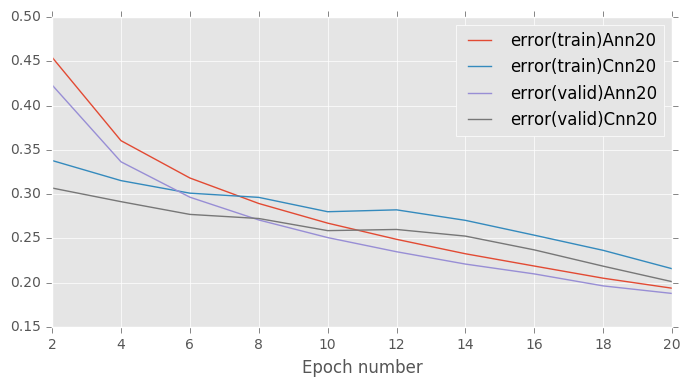

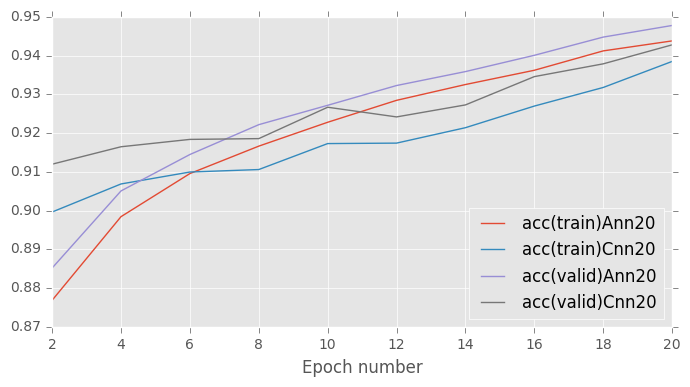

In [53]:
#Compare ann and cnn
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    #ax_1.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label="Ann50")
    #ax_1.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label="Ann100")
   
    ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    #ax_1.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label="Cnn50")
    #ax_1.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label="Cnn100")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    #ax_2.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label="Ann50")
    #ax_2.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label="Ann100")
    
    ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    #ax_2.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label="Cnn50")
    #ax_2.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label="Cnn100")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('20ann&cnnerr.png')
fig_2.savefig('20ann&cnnacc.png')

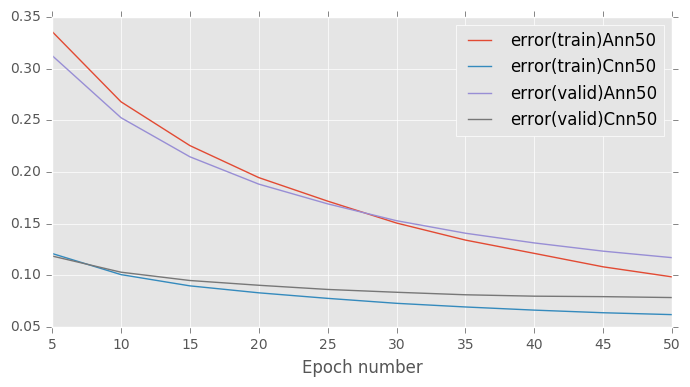

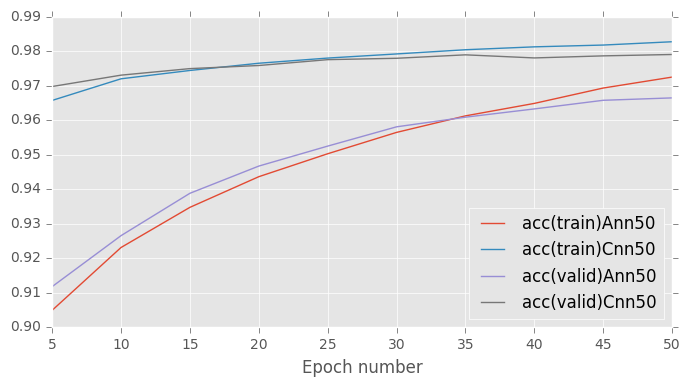

In [29]:
#Compare ann and cnn
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    #ax_1.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    ax_1.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label=k+"Ann50")
    #ax_1.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label="Ann100")
   
    #ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    ax_1.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label=k+"Cnn50")
    #ax_1.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label="Cnn100")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    #ax_2.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    ax_2.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label=k+"Ann50")
    #ax_2.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label="Ann100")
    
    #ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    ax_2.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label=k+"Cnn50")
    #ax_2.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label="Cnn100")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('50ann&cnnerr.png')
fig_2.savefig('50ann&cnnacc.png')

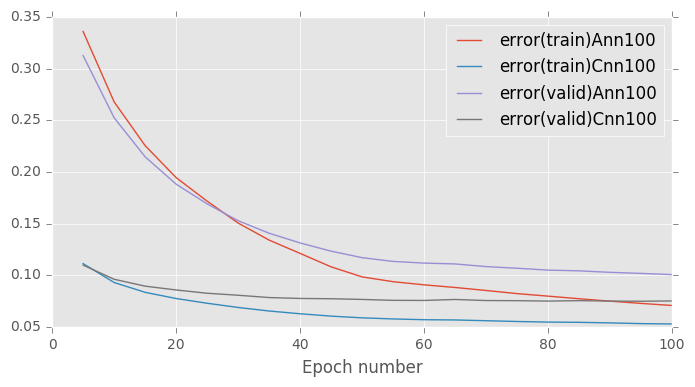

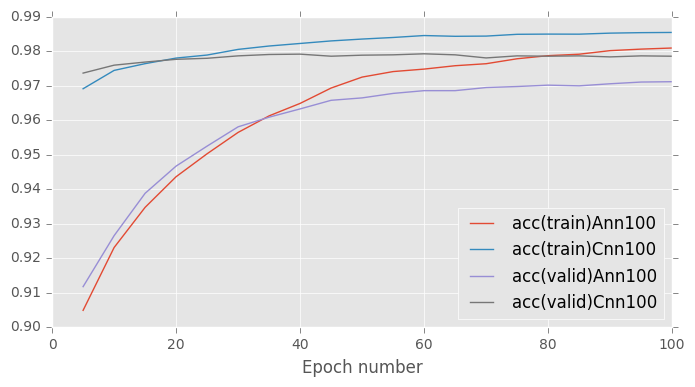

In [30]:
#Compare ann and cnn
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    #ax_1.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    #ax_1.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label="Ann50")
    ax_1.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label=k+"Ann100")
   
    #ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    #ax_1.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label="Cnn50")
    ax_1.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label=k+"Cnn100")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    #ax_2.plot(np.arange(1, stats2.shape[0]) * stats_interval, stats2[1:, keys2[k]], label=k+"Ann20")
    #ax_2.plot(np.arange(1, stats5.shape[0]) * stats_interval, stats5[1:, keys5[k]], label="Ann50")
    ax_2.plot(np.arange(1, stats10.shape[0]) * stats_interval, stats10[1:, keys10[k]], label=k+"Ann100")
    
    #ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"Cnn20")
    #ax_2.plot(np.arange(1, stats50.shape[0]) * stats_interval, stats50[1:, keys50[k]], label="Cnn50")
    ax_2.plot(np.arange(1, stats100.shape[0]) * stats_interval, stats100[1:, keys100[k]], label=k+"Cnn100")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('100ann&cnnerr.png')
fig_2.savefig('100ann&cnnacc.png')

In [36]:
#S10

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_S10

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

statsS10,keysS10,run_timeS10 = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

_ = statsS10, keysS10, run_timeS10

Epoch 0:
  error(train)=2.31e+00, acc(train)=9.98e-02, error(valid)=2.31e+00, acc(valid)=9.61e-02, params_penalty=0.00e+00
Epoch 2: 159.43s to complete
  error(train)=3.45e-01, acc(train)=8.98e-01, error(valid)=3.14e-01, acc(valid)=9.09e-01, params_penalty=0.00e+00
Epoch 4: 159.92s to complete
  error(train)=3.23e-01, acc(train)=9.03e-01, error(valid)=2.99e-01, acc(valid)=9.15e-01, params_penalty=0.00e+00
Epoch 6: 160.27s to complete
  error(train)=3.06e-01, acc(train)=9.08e-01, error(valid)=2.82e-01, acc(valid)=9.17e-01, params_penalty=0.00e+00
Epoch 8: 159.13s to complete
  error(train)=3.02e-01, acc(train)=9.08e-01, error(valid)=2.78e-01, acc(valid)=9.17e-01, params_penalty=0.00e+00
Epoch 10: 159.89s to complete
  error(train)=2.84e-01, acc(train)=9.17e-01, error(valid)=2.62e-01, acc(valid)=9.25e-01, params_penalty=0.00e+00
Epoch 12: 160.09s to complete
  error(train)=2.80e-01, acc(train)=9.18e-01, error(valid)=2.58e-01, acc(valid)=9.24e-01, params_penalty=0.00e+00
Epoch 14: 159.49s

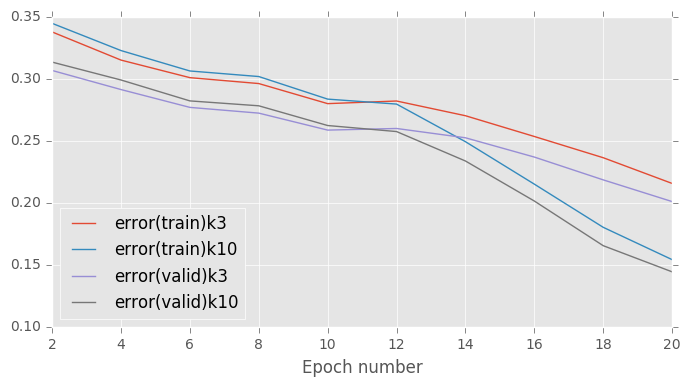

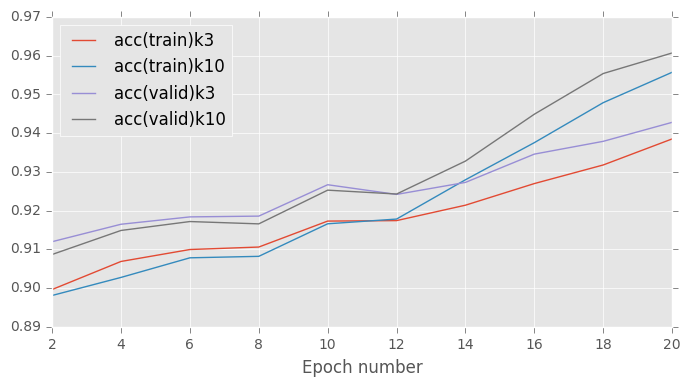

In [56]:
#Compare the influence of number of kernel in cnn
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    
    ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"k3")
    ax_1.plot(np.arange(1, statsS10.shape[0]) * stats_interval, statsS10[1:, keysS10[k]], label=k+"k10")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"k3")
    ax_2.plot(np.arange(1, statsS10.shape[0]) * stats_interval, statsS10[1:, keysS10[k]], label=k+"k10")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('kann&cnnerr.png')
fig_2.savefig('kann&cnnacc.png')

In [ ]:
#b-20epoch

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_b

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
#plot
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

statsbbb,keysbbb,run_timebbb = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

_ = statsbbb, keysbbb, run_timebbb

Epoch 0:
  error(train)=2.31e+00, acc(train)=1.02e-01, error(valid)=2.31e+00, acc(valid)=1.03e-01, params_penalty=0.00e+00
Epoch 2: 181.52s to complete
  error(train)=2.94e-01, acc(train)=9.15e-01, error(valid)=2.62e-01, acc(valid)=9.27e-01, params_penalty=0.00e+00
Epoch 4: 177.73s to complete
  error(train)=2.47e-01, acc(train)=9.28e-01, error(valid)=2.25e-01, acc(valid)=9.35e-01, params_penalty=0.00e+00
Epoch 6: 182.28s to complete
  error(train)=2.04e-01, acc(train)=9.41e-01, error(valid)=1.86e-01, acc(valid)=9.48e-01, params_penalty=0.00e+00


In [31]:
# R

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

rng.seed(seed)
train_data.reset()
valid_data.reset()
# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)


weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_R

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

statsR, keysR, run_timeR = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = statsR, keysR, run_timeR

Epoch 0:
  error(train)=2.36e+00, acc(train)=8.87e-02, error(valid)=2.35e+00, acc(valid)=9.06e-02, params_penalty=0.00e+00
Epoch 2: 31.41s to complete
  error(train)=1.04e-01, acc(train)=9.68e-01, error(valid)=1.26e-01, acc(valid)=9.64e-01, params_penalty=0.00e+00
Epoch 4: 32.96s to complete
  error(train)=8.41e-02, acc(train)=9.74e-01, error(valid)=1.12e-01, acc(valid)=9.67e-01, params_penalty=0.00e+00
Epoch 6: 31.07s to complete
  error(train)=7.32e-02, acc(train)=9.77e-01, error(valid)=1.07e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 8: 32.57s to complete
  error(train)=6.58e-02, acc(train)=9.80e-01, error(valid)=1.04e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 10: 30.57s to complete
  error(train)=5.91e-02, acc(train)=9.81e-01, error(valid)=1.02e-01, acc(valid)=9.71e-01, params_penalty=0.00e+00
Epoch 12: 29.45s to complete
  error(train)=5.40e-02, acc(train)=9.84e-01, error(valid)=9.86e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 14: 30.29s to com

In [32]:
# T

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_T

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 20  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

statsT, keysT, run_timeT = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = statsT, keysT, run_timeT

Epoch 0:
  error(train)=2.31e+00, acc(train)=8.17e-02, error(valid)=2.31e+00, acc(valid)=7.76e-02, params_penalty=0.00e+00
Epoch 2: 31.97s to complete
  error(train)=8.35e-02, acc(train)=9.76e-01, error(valid)=9.06e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 4: 32.23s to complete
  error(train)=6.96e-02, acc(train)=9.81e-01, error(valid)=8.33e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 6: 32.58s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=8.03e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 8: 32.95s to complete
  error(train)=5.88e-02, acc(train)=9.84e-01, error(valid)=7.82e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 10: 31.48s to complete
  error(train)=5.67e-02, acc(train)=9.84e-01, error(valid)=8.02e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 12: 31.78s to complete
  error(train)=5.26e-02, acc(train)=9.86e-01, error(valid)=7.85e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 14: 31.59s to com

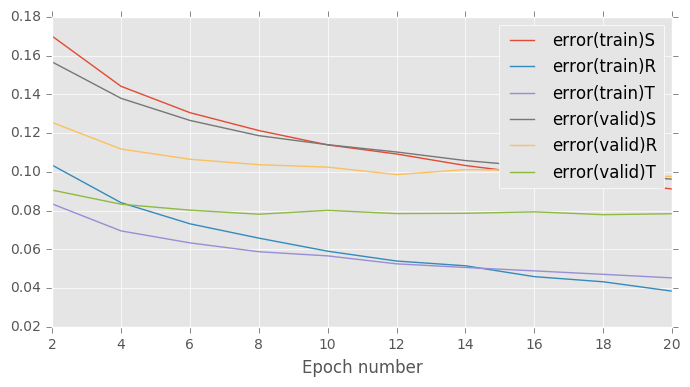

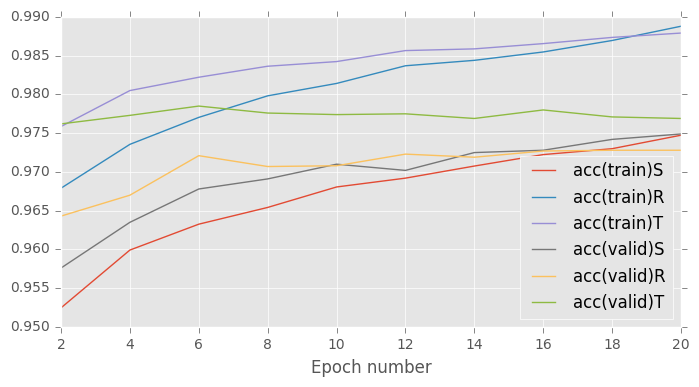

In [33]:
#Compare 3 different activation function
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_1.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
    ax_1.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_2.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
    ax_2.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('3Aann&cnnerr.png')
fig_2.savefig('3Aann&cnnacc.png')

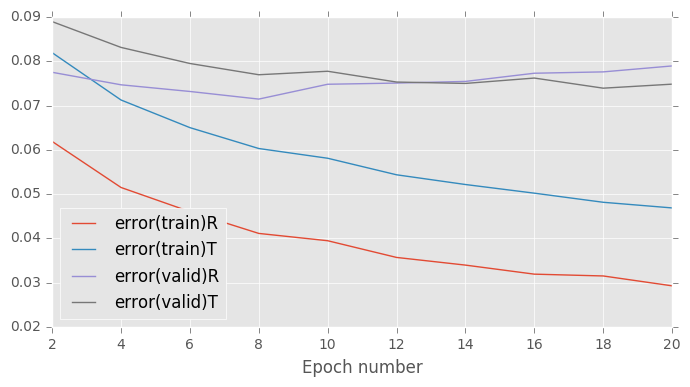

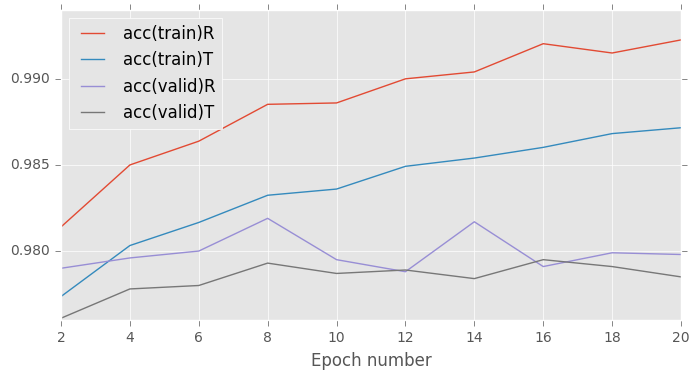

In [59]:
#Compare different activation function
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    #ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_1.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
    ax_1.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    #ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_2.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
    ax_2.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('Aann&cnnerr.png')
fig_2.savefig('Aann&cnnacc.png')

In [34]:
# R

# Seed a random number generator


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

rng.seed(seed)
train_data.reset()
valid_data.reset()
# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)


weights_init = GlorotUniformInit(rng=rng)
biases_init = ConstantInit(0.)

model = model_base_R

error = CrossEntropySoftmaxError()
# Set training run hyperparameters
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 2  # epoch interval between recording and printing stats
learning_rate_decay = 50
# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

#schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
#schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# _ = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
#_1 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
#_2 = train_model_and_plot_stats(
#    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

statsR, keysR, run_timeR = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
_ = statsR, keysR, run_timeR

Epoch 0:
  error(train)=2.20e-01, acc(train)=9.41e-01, error(valid)=2.65e-01, acc(valid)=9.37e-01, params_penalty=0.00e+00
Epoch 2: 30.81s to complete
  error(train)=3.89e-02, acc(train)=9.88e-01, error(valid)=9.90e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 4: 29.31s to complete
  error(train)=3.46e-02, acc(train)=9.89e-01, error(valid)=9.98e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 6: 29.20s to complete
  error(train)=3.17e-02, acc(train)=9.90e-01, error(valid)=9.94e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 8: 29.31s to complete
  error(train)=3.14e-02, acc(train)=9.91e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 10: 30.22s to complete
  error(train)=2.97e-02, acc(train)=9.91e-01, error(valid)=1.02e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 12: 30.36s to complete
  error(train)=2.69e-02, acc(train)=9.92e-01, error(valid)=1.00e-01, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 14: 30.34s to com

KeyboardInterrupt: 

In [ ]:
#Compare different activation function
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    #ax_1.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_1.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
#     ax_1.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")
    
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')


fig_2 = plt.figure(figsize=(8, 4))
ax_2 = fig_2.add_subplot(111)
for k in ['acc(train)', 'acc(valid)']:
    #ax_2.plot(np.arange(1, stats20.shape[0]) * stats_interval, stats20[1:, keys20[k]], label=k+"S")
    ax_2.plot(np.arange(1, statsR.shape[0]) * stats_interval, statsR[1:, keysR[k]], label=k+"R")
#     ax_2.plot(np.arange(1, statsT.shape[0]) * stats_interval, statsT[1:, keysT[k]], label=k+"T")

ax_2.legend(loc=0)
ax_2.set_xlabel('Epoch number')
    
_=fig_1, ax_1, fig_2, ax_2
    
fig_1.savefig('Aann&cnnerr.png')
fig_2.savefig('Aann&cnnacc.png')

In [36]:
# model_base_SD = MultipleLayerModel([
#         ReshapeLayer((28,28)),
#         cnnlayer_base,
#         SigmoidLayer(),
#         ConvolutionalLayer(
#                     num_input_channels=3, 
#                     num_output_channels=3, 
#                     input_dim_1=24, 
#                     input_dim_2=24,
#                     kernel_dim_1=5,
#                     kernel_dim_2=5
#                 ),
#         SigmoidLayer(),
#         MaxPoolingLayer(),
#         ReshapeLayer(),
#         AffineLayer(240, output_dim, param_init, param_init),
#     ])

In [37]:
# #SD

# # Seed a random number generator


# # Set up a logger object to print info about the training run to stdout
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)
# logger.handlers = [logging.StreamHandler()]

# # Create data provider objects for the MNIST data set
# train_data = MNISTDataProvider('train', batch_size=50, rng=rng)
# valid_data = MNISTDataProvider('valid', batch_size=50, rng=rng)

# weights_init = GlorotUniformInit(rng=rng)
# biases_init = ConstantInit(0.)

# model = model_base_SD

# error = CrossEntropySoftmaxError()
# # Set training run hyperparameters
# init_scale = 0.01  # scale for random parameter initialisation
# learning_rate = 0.1  # learning rate for gradient descent
# num_epochs = 20  # number of training epochs to perform
# stats_interval = 1  # epoch interval between recording and printing stats
# learning_rate_decay = 50
# # Reset random number generator and data provider states on each run
# # to ensure reproducibility of results
# rng.seed(seed)
# train_data.reset()
# valid_data.reset()

# # Create a parameter initialiser which will sample random uniform values
# # from [-init_scale, init_scale]
# param_init = UniformInit(-init_scale, init_scale, rng=rng)

# # Use a basic gradient descent learning rule
# learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

# schedulers1=[ExponentialLearningRateScheduler(init_learning_rate=learning_rate,decay_param=learning_rate_decay)]

# #schedulers2=[ReciprocalLearningRateScheduler(learning_rate=learning_rate,learning_rate_decay=learning_rate_decay)]
# #schedulers3=[ConstantLearningRateScheduler(learning_rate=learning_rate)]

# # _ = train_model_and_plot_stats(
# #     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers1,'cnn')
# #_1 = train_model_and_plot_stats(
# #    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers2)
# #_2 = train_model_and_plot_stats(
# #    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval, schedulers3)
# data_monitors={'acc':lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
# optimiser = Optimiser(model,error,learning_rule,train_data,valid_data,data_monitors,schedulers1)

# statsSD, keysSD, run_timeSD = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)
# _ = statsSD, keysSD, run_timeSD

ValueError: shapes (10,240) and (600,50) not aligned: 240 (dim 1) != 600 (dim 0)